In [32]:
import ot
import sgw
import scanpy as sc
import pandas as pd
import numpy as np
import networkx as nx
from geosketch import gs
import matplotlib.pyplot as plt

In [33]:
def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    for i in range(P.shape[0]):
        if P[i,:].sum() < thresh: continue
        j = np.argmax(P[i,:])
        ax.plot3D([X_1[i,0], X_2[j,0]],[X_1[i,1], X_2[j,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])

In [34]:
import plotly 
plotly_colors = plotly.colors.qualitative.Plotly

# **Partially overlapping simulated data**

In [68]:
dataname = './data/dyntoy_bifurcating_3.h5ad'

In [69]:
adata = sc.read_h5ad(dataname)
print(adata)

AnnData object with n_obs × n_vars = 359 × 5460
    uns: 'milestone_network'
    obsm: 'milestone_percentages'


In [70]:
ms_names = np.array(adata.obsm['milestone_percentages'].columns.values, str)
adata.obs['milestones'] = pd.Series(list(ms_names[np.argmax(adata.obsm['milestone_percentages'],axis=1)]), dtype="category").values

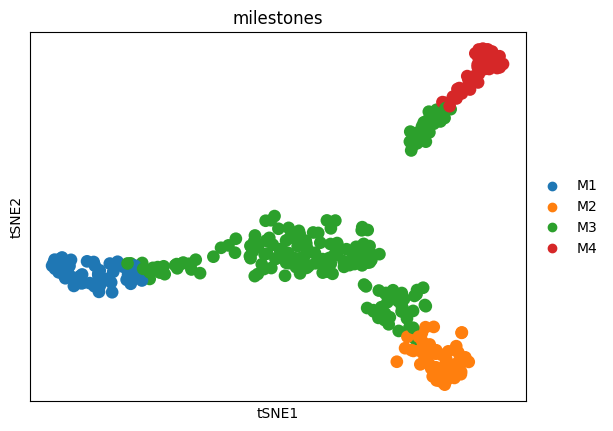

In [71]:
n_pcs = 10
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=n_pcs)
sc.tl.tsne(adata, n_pcs=n_pcs)
sc.pl.tsne(adata, color=['milestones'])

In [72]:
A = adata.obsp['distances']
G = nx.from_numpy_array(A)
ncell = A.shape[0]

In [73]:
p = dict(nx.shortest_path_length(G, weight='weight'))

In [74]:
D = np.array([[p[i][j] for i in range(ncell)] for j in range(ncell)])

In [75]:
adata.obsp['geodesics'] = D

In [76]:
X_pca = adata.obsm['X_pca'][:,:n_pcs]
# downsample_index = sgw.downsample_data(X_pca, gs_N=50, random_state=547, method='geosketch')
downsample_index = sgw.downsample_data(X_pca[:,:2], random_state=547, method='mapper')
print(len(downsample_index))

30


In [77]:
adata_sub = adata[downsample_index]
adata_sub_1 = adata_sub[adata_sub.obs['milestones'].isin(['M1','M3']),:]
adata_sub_2 = adata_sub[adata_sub.obs['milestones'].isin(['M3','M2','M4']),:]
adata_1 = adata[adata.obs['milestones'].isin(['M1','M3']),:]
adata_2 = adata[adata.obs['milestones'].isin(['M3','M2','M4']),:]

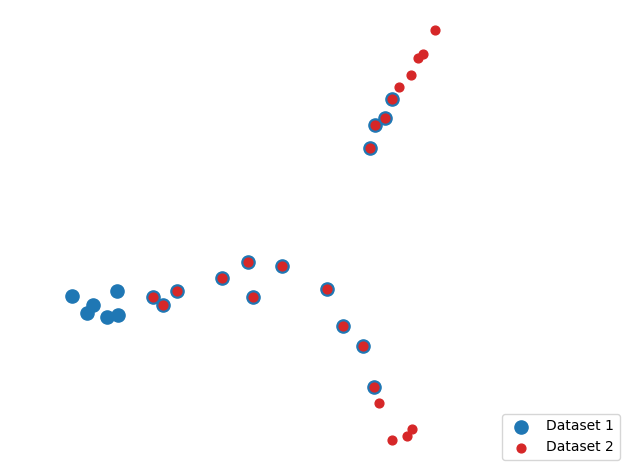

In [78]:
plt.scatter(adata_sub_1.obsm['X_tsne'][:,0], adata_sub_1.obsm['X_tsne'][:,1], label='Dataset 1', c='tab:blue', s=90)
plt.scatter(adata_sub_2.obsm['X_tsne'][:,0], adata_sub_2.obsm['X_tsne'][:,1], label='Dataset 2', c='tab:red', s=40)
plt.legend(loc=[1.01,0])
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig("./figures/sim_scatter_downsample_twodatasets_partialoverlap.pdf")

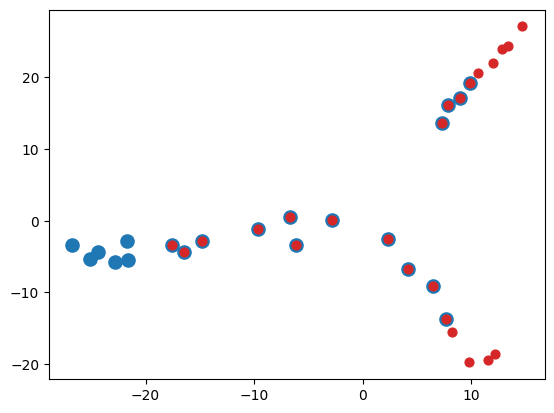

In [79]:
plt.scatter(adata_sub_1.obsm['X_tsne'][:,0], adata_sub_1.obsm['X_tsne'][:,1], label='Dataset 1', c='tab:blue', s=90)
plt.scatter(adata_sub_2.obsm['X_tsne'][:,0], adata_sub_2.obsm['X_tsne'][:,1], label='Dataset 2', c='tab:red', s=40)

In [80]:
D_1 = adata_sub_1.obsp['geodesics']
D_2 = adata_sub_2.obsp['geodesics']
X_1 = adata_sub_1.obsm['X_tsne']
X_2 = adata_sub_2.obsm['X_tsne']

In [48]:
thresholds = [0.5, 1, 3, 5, 10, 20]

In [49]:
SGW_list = []
for i in range(len(thresholds)):
    print(i)
    P = sgw.supervised_gromov_wasserstein(D_1/D_1.max(), D_2/D_1.max(), nitermax=20, threshold=thresholds[i]/D_1.max(), eps=1e-1)
    SGW_list.append(P)
    plot_mapping(P, X_1, X_2, thresh=0.1/X_2.shape[0])
    plt.savefig("./figures/simulated_SGW_%d.pdf" % (i+1))
    # plt.show()
    plt.clf()

0
1
2
3
4
5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [81]:
n1 = D_1.shape[0]
n2 = D_2.shape[0]
a = np.ones(n1) / n1
b = np.ones(n2) / n2
m_list = [0.1, 0.3, 0.5, 0.7, 0.9, 0.9999]
PGW_list = []
for i in range(len(m_list)):
    m = m_list[i]
    P = ot.partial.entropic_partial_gromov_wasserstein(D_1/D_1.max(), D_2/D_1.max(), a, b, 1e-1, m = m)
    PGW_list.append(P)
    plot_mapping(P, X_1, X_2, thresh=0.1/X_2.shape[0])
    plt.savefig("./figures/simulated_PGW_%d.pdf" % (i+1))
    # plt.show()
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
import torch
from unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn, log_ugw_sinkhorn

In [53]:
eps = 1.0
aa = torch.from_numpy(a)
bb = torch.from_numpy(b)
dx = torch.from_numpy(D_1)
dy = torch.from_numpy(D_2)
rhos = [0.5, 1.0, 5.0, 10.0, 100.0, np.inf]
pi_list = []
gamma_list = []
for i in range(len(rhos)):
    pi, gamma = log_ugw_sinkhorn(aa, dx, bb, dy, init=None, eps=eps,
         rho=rhos[i], rho2=rhos[i],
         nits_plan=1000, tol_plan=1e-5,
         nits_sinkhorn=1000, tol_sinkhorn=1e-5,
         two_outputs=True)
    pi_list.append(pi.numpy())
    gamma_list.append(gamma.numpy())

In [54]:
for i in range(6):
    P = pi_list[i]
    plot_mapping(P, X_1, X_2, thresh=0.1/X_2.shape[0])
    plt.savefig("./figures/simulated_UGW_%d.pdf" % (i+1))
    # plt.show()
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# **Slightly overlapping real data**

In [50]:
adata = sc.read_h5ad('./data/adata.h5ad')

In [51]:
adata

AnnData object with n_obs × n_vars = 1222 × 2288
    uns: 'milestone_network'
    obsm: 'milestone_percentages'

In [52]:
ms_names = np.array(adata.obsm['milestone_percentages'].columns.values, str)
adata.obs['milestones'] = pd.Series(list(ms_names[np.argmax(adata.obsm['milestone_percentages'],axis=1)]), dtype="category").values

In [53]:
n_pcs = 20
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.tsne(adata, n_pcs=n_pcs)
X_tsne = adata.obsm['X_tsne']

In [54]:
X_pca = adata.obsm['X_pca'][:,:20]

In [55]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
A = adata.obsp['distances']
G = nx.from_numpy_array(A)
ncell = A.shape[0]

In [56]:
p = dict(nx.shortest_path_length(G, weight='weight'))

In [57]:
D = np.array([[p[i][j] for i in range(ncell)] for j in range(ncell)])

In [58]:
adata.obsp['geodesics'] = D

In [59]:
idx = sgw.downsample_data(X_pca[:,:3], method='mapper', km_n_cubes=10, km_perc_overlap=0.2)
print(len(idx))

89


In [60]:
milestone_set_1 = ['Endothelial cell_Aqp1 high(Mammary-Gland-Involution)',
 'Labyrinthine trophoblast(Placenta)',
 'Progenitor trophoblast_Gjb3 high(Placenta)',
 'Spiral artery trophoblast giant cells(Placenta)',
 'Endothelial cell_Fabp4&Aqp1 high(Mammary-Gland-Involution)',
 'Endothelial cell_Fabp4 high(Mammary-Gland-Involution)']

milestone_set_2 = [
 'Progenitor trophoblast_Gjb3 high(Placenta)',
 'Spongiotrophoblast_Hsd11b2 high(Placenta)',
 'Spongiotrophoblast_Phlda2 high(Placenta)']

In [61]:
adata_sub = adata[idx]
adata_sub_1 = adata_sub[adata_sub.obs['milestones'].isin(milestone_set_1),:]
adata_sub_2 = adata_sub[adata_sub.obs['milestones'].isin(milestone_set_2),:]
adata_1 = adata[adata.obs['milestones'].isin(milestone_set_1),:]
adata_2 = adata[adata.obs['milestones'].isin(milestone_set_2),:]

In [62]:
D_1 = adata_sub_1.obsp['geodesics']
D_2 = adata_sub_2.obsp['geodesics']
X_1 = adata_sub_1.obsm['X_tsne']
X_2 = adata_sub_2.obsm['X_tsne']
print(D_1.shape, D_2.shape)

(71, 71) (41, 41)


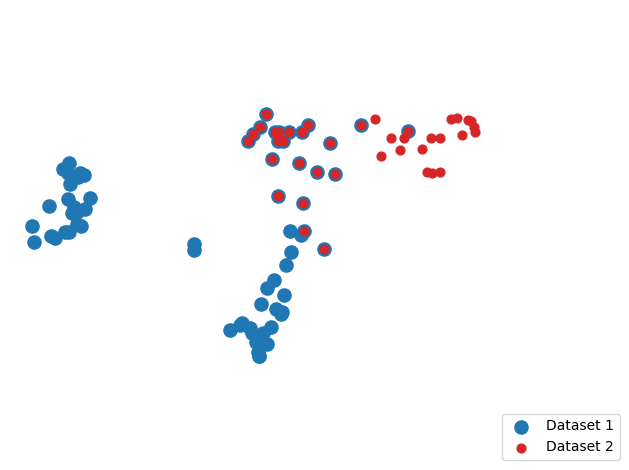

In [63]:
plt.scatter(adata_sub_1.obsm['X_tsne'][:,0], adata_sub_1.obsm['X_tsne'][:,1], label='Dataset 1', c='tab:blue', s=90)
plt.scatter(adata_sub_2.obsm['X_tsne'][:,0], adata_sub_2.obsm['X_tsne'][:,1], label='Dataset 2', c='tab:red', s=40)
plt.legend(loc=[1.01,0])
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig("./figures/real_scatter_downsample_twodatasets_slightoverlap.pdf")

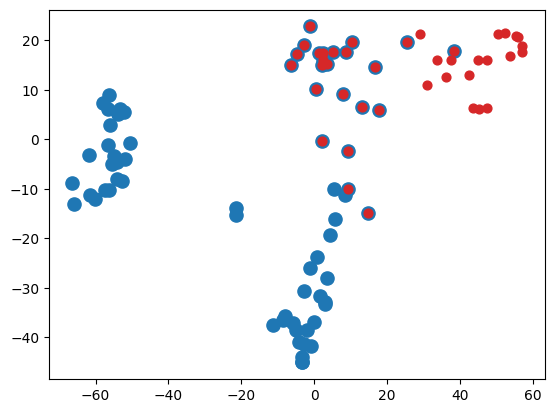

In [64]:
plt.scatter(adata_sub_1.obsm['X_tsne'][:,0], adata_sub_1.obsm['X_tsne'][:,1], label='Dataset 1', c='tab:blue', s=90)
plt.scatter(adata_sub_2.obsm['X_tsne'][:,0], adata_sub_2.obsm['X_tsne'][:,1], label='Dataset 2', c='tab:red', s=40)

In [65]:
thresholds = [0.5, 1, 3, 5, 10, 20]

In [66]:
SGW_list = []
for i in range(len(thresholds)):
    print(i)
    P = sgw.supervised_gromov_wasserstein(D_1/D_1.max(), D_2/D_1.max(), nitermax=20, threshold=thresholds[i]/D_1.max(), eps=1e-1)
    SGW_list.append(P)
    plot_mapping(P, X_1, X_2, thresh=0.1/X_2.shape[0])
    plt.savefig("./figures/real_SGW_%d.pdf" % (i+1))
    # plt.show()
    plt.clf()

0
1
2
3
4
5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [67]:
n1 = D_1.shape[0]
n2 = D_2.shape[0]
a = np.ones(n1) / n1
b = np.ones(n2) / n2
m_list = [0.1, 0.3, 0.5, 0.7, 0.9, 0.9999]
PGW_list = []
for i in range(len(m_list)):
    m = m_list[i]
    P = ot.partial.entropic_partial_gromov_wasserstein(D_1/D_1.max(), D_2/D_1.max(), a, b, 1e-1, m = m)
    PGW_list.append(P)
    plot_mapping(P, X_1, X_2, thresh=0.1/X_2.shape[0])
    plt.savefig("./figures/real_PGW_%d.pdf" % (i+1))
    # plt.show()
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [78]:
eps = 1.0
aa = torch.from_numpy(a)
bb = torch.from_numpy(b)
dx = torch.from_numpy(D_1)
dy = torch.from_numpy(D_2)
rhos = [0.5, 1.0, 5.0, 10.0, 100.0, np.inf]
pi_list = []
gamma_list = []
for i in range(len(rhos)):
    pi, gamma = log_ugw_sinkhorn(aa, dx, bb, dy, init=None, eps=eps,
         rho=rhos[i], rho2=rhos[i],
         nits_plan=1000, tol_plan=1e-5,
         nits_sinkhorn=1000, tol_sinkhorn=1e-5,
         two_outputs=True)
    pi_list.append(pi.numpy())
    gamma_list.append(gamma.numpy())

In [79]:
for i in range(6):
    P = pi_list[i]
    plot_mapping(P, X_1, X_2, thresh=0.1/X_2.shape[0])
    plt.savefig("./figures/real_UGW_%d.pdf" % (i+1))
    # plt.show()
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>